## Title: Movie Critic Prediction Using Advance Machine Learning
* Presented By: Sruthi Puthiyandy
* Supervised By: Prof. Dr. Yasin Ceren
#### Why this topic choosen
In todays highly competetive streaming and entertainment world the never untiring hobby is watching interesting shows among all age groups aspecially in this eara. Companies like Netflix, Apple TV+, Amazon Prime Video, and Disney+ rely heavly on data and machine learning to make critical business decisions and enhance user experience to make their channel adapted by wide range of users. Predicting how well a movie will be recieved, whether by critics or audiences is a crucial piece of this puzzle. This helps the streaming platform acuisitioning the or investing millions in particular green projects which will attract more subscriptions. And the provider can suggest better recommendations. For example Netflix uses a sophisticated algorithm to predict what each user enjoy, influencing what appears on their home page, their viewing pattern, their subscription retension.While they typically focus on predicting user ratings, understanding general critical sentiment can feed into these systems as a broader quality signal. By this project my intension is - 
* Use more intense and adavanced Machine Learning approches
* Working with real world data and get exposure to real world project that is dealt in FANG companies or major tech companies
* Using major predictive algorithms learned
* Leveraging domain knowledge into feature engineering to build effective models
* IDentification of different feature and it's effect on rating
* Using of matrics accuracy, precision, recall, F1-score (for classification), or RMSE, MAE (for regression) to objectively evaluate your model's performance, which is essential to warp up the ML modeling.


## Vision 
The primary goal from this project is to predict the tomatometer rating which is highly accurate using a machine learning model by using the dataset got from rotten tomatoes streaming website dataset for movies based on various numerical and textual attributes. The tomatometer rating represents the aggregated percentage of positive reviews from critics. 

### About dataset
* Collected from : Keggles.com
* Original source : scraped from the publicly available website https://www.rottentomatoes.com as of 2020-10-31
* Total number of rows: 17712
* Shape of the data: (17712, 22)
* Duplicates : Present in multiple column inclusing target variable
* NULL values: Present in multiple columns inclusing target variables
* Datatype: int64, float64, object

### Details about each columns
* rotten_tomatoes_link: Represents a unique identifier on the movie on the rotten tomatto website. It is the part of the URL that identifies the movie. It's primarily for identification, generally not used as a direct feautre.
* movie_title: The full title of the movie
* movie_info: A brief plot summary or description of the movie.
* critics_consensus: A short summery written by rotten tomatoes staff that encapsulates the general critical opinion of the film.
* content_rating: The movie rating based on the suitability for audiences, typically assigned by rating boards like MPAA in the US. 
    * G  - General Audiance, suitable for all ages.
    * PG - Parental Guidance Suggested, some material may not be suitable for children
    * PG-13 - Parents strongly cautioned, some meterial may be inappropriate for children under 13
    * R  - Restricted, restricted to viewers over 18, unless accompanied by parent or guardian
    * NC-17 - Adults only, no one 17 and under admitted
    * NR - Not rated, no official rating by MPA
* genres: The category of the movie like drama, horror, adventure and multiple categories are comma seperated in this column
* directors: The name of the movie's director, multiple directors can be possible
* authors: Name of screenplay writers
* actors: The names of the primary actor in the movie.
* original_release_date: The initial theatrical release of the movie.
* streaming_release_date: The date the movie became available on streaming platforms.
* runtime: The duration of the movie in minutes. 
* production_company: The studio company that produced the movie.
* tomatometer_status: A qualitiative label assigned by rotten tomatoes to summerize critic reception: Fresh, certified or rotten.
* tomatometer_rating: The percentage of professional critic reviews that are positive for a given film. This is a score out of 100 which is equal to (number of fresh critic reviews/Total number of critic reviews) X 100.
* tomatometer_count: Total number of critic reviews that have been counted towards the tomatometer_rating.
* audience_status: A qualitative label based on user ratings; "upright" (full popcorn bucket) or "spilled" (negative, tipped popcorn bucket)
* audience_rating: The percentage of verified users who have rated the movie positively. this score out of 100. And it is equal to (number of positive rating/total number of rating)X100
* audience_count: The total number of audience ratings counted for the audience_rating value.
* tomatometer_top_critics_count: The total number of rating from "Top Critics" 
* tomatometer_fresh_critics_count: The number of critic review categorized as "Fresh"
* tomatometer_rotten_critics_count: The number of critic count categorized by "Rotten"

### Dataset attribute understanding 
* **Target Data: tomatometer_rating**
* **Text Data: movie_info, critics_consensus** are long text and essential and crucial for deriving the prediction
* **Categorical Data: content_rating, genres, directors, authors, actors, production_company, tomatometer_status, audience_status**. These provide rich contextual information about the movie's type, creators, and audience perception. We can use it for the recommendations as well.
* **Numerical Data: runtime, tomatometer_count, audience_rating, audience_count, tomatometer_top_critics_count, tomatometer_fresh_critics_count, tomatometer_rotten_critics_count**. These metrics quantify various aspects of a film's critical and audience engagement.
* **Temporal Data: original_release_date, streaming_release_date**. These can provide insights into release strategies and trends.

#### Project Environment setup:
*	Programming Language: Python 3.13.5
*	IDE: Visual Studio Code (VS Code)
*	Operating System: Windows 11 Pro
*	Processor: 12th Gen Intel® Core™ i5-1235U @ 1.30 GHz
*	Python Libraries : scikit-learn (sklearn), pandas, numpy, matplotlib, seaborn, streamlit (for local model deployment), imbalanced-learn

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import  OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [57]:
# --- Custom Transformers Definition ---
# These classes must be identical in both train_model.ipynb and streamlit_app.py
# for joblib.load to work correctly.

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=None):
        self.mlb = MultiLabelBinarizer()
        self.top_n = top_n
        self.selected_classes_ = None # Store the actual classes selected after fit

    def fit(self, X, y=None):
        # Flatten the list of lists to count frequencies of all entities
        all_entities = []
        for val in X:
            # Ensure val is treated as string, split, strip, and filter out empty/Unknown
            entities = [e.strip() for e in str(val).split(',') if e.strip() and e.strip() != 'Unknown']
            all_entities.extend(entities)

        if self.top_n is not None:
            # Get the N most common entities
            entity_counts = Counter(all_entities)
            # Ensure top_n doesn't exceed the actual number of unique entities
            current_top_n = min(self.top_n, len(entity_counts))
            self.selected_classes_ = [entity for entity, count in entity_counts.most_common(current_top_n)]
        else:
            # If no top_n specified, use all unique entities
            self.selected_classes_ = sorted(list(set(all_entities)))

        # Fit the MultiLabelBinarizer on the selected classes
        self.mlb.fit([self.selected_classes_]) # Fit with a list containing the list of all classes
        return self

    def transform(self, X):
        transformed_data = []
        for val in X:
            # Ensure val is treated as string, split, strip, and filter out empty/Unknown
            entities = [e.strip() for e in str(val).split(',') if e.strip() and e.strip() != 'Unknown']
            # Filter entities to only include those that were selected during fit
            filtered_entities = [entity for entity in entities if entity in self.selected_classes_]
            transformed_data.append(filtered_entities)

        # Transform the filtered entities
        return self.mlb.transform(transformed_data)

    def get_feature_names_out(self, input_features=None):
        # Return the classes that the internal MLB was fitted on
        return self.mlb.classes_


class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.median_delay = pd.Timedelta(days=365) # Default median delay

    def fit(self, X, y=None):
        X_df = X.copy()
        X_df['original_release_date'] = pd.to_datetime(X_df['original_release_date'], errors='coerce')
        X_df['streaming_release_date'] = pd.to_datetime(X_df['streaming_release_date'], errors='coerce')

        valid_dates_mask = X_df['original_release_date'].notnull() & \
                           X_df['streaming_release_date'].notnull() & \
                           (X_df['streaming_release_date'] >= X_df['original_release_date'])

        if valid_dates_mask.any():
            delay = X_df.loc[valid_dates_mask, 'streaming_release_date'] - \
                    X_df.loc[valid_dates_mask, 'original_release_date']
            if not delay.empty:
                self.median_delay = delay.median()
        return self

    def transform(self, X):
        X_df = X.copy()
        X_df['original_release_date'] = pd.to_datetime(X_df['original_release_date'], errors='coerce')
        X_df['streaming_release_date'] = pd.to_datetime(X_df['streaming_release_date'], errors='coerce')

        # Fix: Avoid inplace=True on chained assignment
        mask_orig_missing_stream_present = X_df['original_release_date'].isnull() & X_df['streaming_release_date'].notnull()
        X_df.loc[mask_orig_missing_stream_present, 'original_release_date'] = \
            X_df.loc[mask_orig_missing_stream_present, 'streaming_release_date'] - self.median_delay

        # Fix: Avoid inplace=True on chained assignment
        mask_stream_missing_orig_present = X_df['streaming_release_date'].isnull() & X_df['original_release_date'].notnull()
        X_df.loc[mask_stream_missing_orig_present, 'streaming_release_date'] = \
            X_df.loc[mask_stream_missing_orig_present, 'original_release_date'] + self.median_delay

        X_df['original_release_year'] = X_df['original_release_date'].dt.year
        X_df['original_release_month'] = X_df['original_release_date'].dt.month
        X_df['original_release_dayofweek'] = X_df['original_release_date'].dt.dayofweek
        X_df['streaming_release_year'] = X_df['streaming_release_date'].dt.year
        X_df['streaming_release_month'] = X_df['streaming_release_date'].dt.month
        X_df['streaming_release_dayofweek'] = X_df['streaming_release_date'].dt.dayofweek

        # Fix: Avoid inplace=True for fillna
        X_df['release_date_diff_days'] = (X_df['streaming_release_date'] - X_df['original_release_date']).dt.days
        X_df['release_date_diff_days'] = X_df['release_date_diff_days'].fillna(0) # Removed inplace=True

        for col in ['original_release_year', 'original_release_month', 'original_release_dayofweek',
                    'streaming_release_year', 'streaming_release_month', 'streaming_release_dayofweek',
                    'release_date_diff_days']:
            X_df[col] = pd.to_numeric(X_df[col], errors='coerce')
            # Fix: Avoid inplace=True for fillna
            X_df[col] = X_df[col].fillna(X_df[col].median() if X_df[col].median() is not np.nan else 0)

        return X_df[['original_release_year', 'original_release_month', 'original_release_dayofweek',
                     'streaming_release_year', 'streaming_release_month', 'streaming_release_dayofweek',
                     'release_date_diff_days']].values

    def get_feature_names_out(self, input_features=None):
        return ['original_release_year', 'original_release_month', 'original_release_dayofweek',
                'streaming_release_year', 'streaming_release_month', 'streaming_release_dayofweek',
                'release_date_diff_days']



#### Load data

In [58]:
# --- 1. Load Data and Initial Preprocessing ---
df = pd.read_csv('rotten_tomatoes_movies.csv')

#### Drop duplicates available in target

In [59]:
# Define target for regression and handle its NaNs
original_rows = len(df)
df.dropna(subset=['tomatometer_rating'], inplace=True)
print(f"Dropped {original_rows - len(df)} rows with missing 'tomatometer_rating'.")

Dropped 44 rows with missing 'tomatometer_rating'.


#### Preprocess design for bag of word for large text

In [60]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#### Feature engineering for movie_info and critical_consenses combine to combined_text_description

In [61]:
df['combined_text_description'] = df['movie_info'].fillna('') + ' ' + df['critics_consensus'].fillna('')
df['combined_text_description'] = df['combined_text_description'].apply(preprocess_text)

#### Date was in Object converted to datetime

In [62]:
# Conver date columns into datetime
df['original_release_date']=pd.to_datetime(df['original_release_date'],errors='coerce')
##coerce - will make the unparceble date into NaT
df['streaming_release_date']=pd.to_datetime(df['streaming_release_date'],errors='coerce')

#### Spliting of dataset into feature and target

In [63]:
X = df.drop(columns=['tomatometer_rating'])
y = df['tomatometer_rating']

In [64]:
## replace all blank and null values with Nan 
X.replace('null',np.nan,inplace=True)

#### spliting data into training and testing set

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # No stratify for regression
print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (14132, 22)
Testing data shape: (3534, 22)


#### Checking missing values

In [66]:
missing_info = X_train.isnull().sum()
missing_info = missing_info[missing_info > 0] 

# missing count, and data type
missing_summary = pd.DataFrame({
    'Missing Count': missing_info,
    'Data Type': X_train.dtypes[missing_info.index]
})
missing_summary

,Missing Count,Data Type
movie_info,212,object
critics_consensus,6819,object
genres,12,object
directors,150,object
authors,1215,object
actors,263,object
original_release_date,897,datetime64[ns]
streaming_release_date,267,datetime64[ns]
runtime,205,float64
production_company,398,object


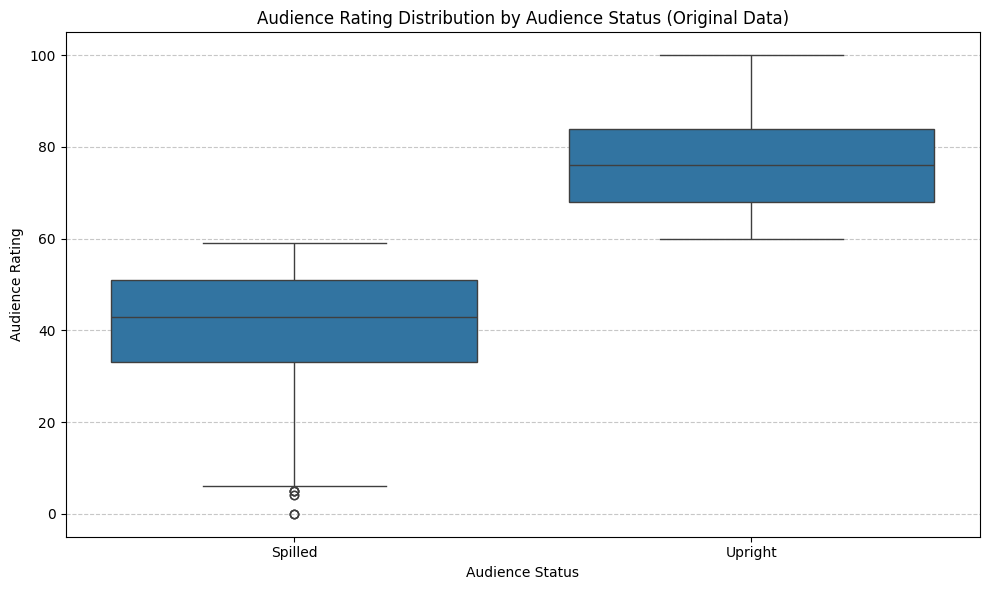

In [67]:
# Create the box plot to visualize the relationship between audience_status and audience_rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='audience_status', y='audience_rating', data=X_train)
plt.title('Audience Rating Distribution by Audience Status (Original Data)')
plt.xlabel('Audience Status')
plt.ylabel('Audience Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping

In [68]:
from sklearn.cluster import KMeans

## Custom pre-procesing or datacleaning before the pipeline

##### 1. Observation 1: audience_rating and audience_status are highly corelated
    * the audience_status = "upright" ---> audience_rating = values from 60 to 100
    * if audience_status = "spilled" ---> audience_rating = values from 0 to 59
In this case we can use upsupervised method for preporcessing.
I am using K-Means clustering for identify the pattern and then imputation of missing values.
From the below EDA we already know that these values are related and how their values spread

In [69]:
# --- Step 1: Confirm pattern using K-Means (for demonstration of unsupervised learning) ---
# this step demonstrates pattern discovery with unsupervised learning.
audience_ratings_for_kmeans = X_train['audience_rating'].dropna().values.reshape(-1, 1)

# Initialize median values for fallback in case K-Means cannot be run
median_upright_rating = 76.0 # Default based on previous analysis
median_spilled_rating = 43.0 # Default based on previous analysis

if len(audience_ratings_for_kmeans) > 0: # Ensure there's data to cluster
    kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
    kmeans.fit(audience_ratings_for_kmeans)
    cluster_centroids = kmeans.cluster_centers_

    # Determine which cluster corresponds to 'Spilled' and 'Upright'
    if cluster_centroids[0] < cluster_centroids[1]:
        median_spilled_rating = cluster_centroids[0][0]
        median_upright_rating = cluster_centroids[1][0]
    else:
        median_spilled_rating = cluster_centroids[1][0]
        median_upright_rating = cluster_centroids[0][0]
else:
    print("Warning: Not enough non-null data for K-Means clustering on audience_rating. Using default median values for imputation.")

print(f"KMeans identified the pattern: median_spilled_rating: {median_spilled_rating} and median_upright_rating : {median_upright_rating}")

# The K-Means step is primarily for pattern confirmation.
actual_median_upright_rating = X_train[X_train['audience_status'] == 'Upright']['audience_rating'].median()
actual_median_spilled_rating = X_train[X_train['audience_status'] == 'Spilled']['audience_rating'].median()
actual_median_spilled_rating

## Imputaytion logic implementation
## In this case data_clean['audience_rating']>=60 and <60 we can impute the value for audience_status
X_train.loc[X_train['audience_status'].isna()&(X_train['audience_rating']>=60),'audience_status']='Upright'
X_train.loc[X_train['audience_status'].isna()&(X_train['audience_rating']<60),'audience_status']='Spilled'


## this is the data_clean['audience_status']=upright or spilled impute the median value for the audience_rating
X_train.loc[X_train['audience_rating'].isna()&(X_train['audience_status']=='Upright'),'audience_rating']=actual_median_upright_rating
X_train.loc[X_train['audience_rating'].isna()&(X_train['audience_status']=='Spilled'),'audience_rating']=actual_median_spilled_rating

## in the case of both audience_rating,audience_status missing we can impute with the overall median value
overall_median=X_train['audience_rating'].median()
overall_median

## impute the calculated value in the audience_rating column
X_train.loc[X_train['audience_rating'].isna(),'audience_rating']=overall_median


## impute values to audience_status column from sudience_rating value imputed in previous step
X_train.loc[X_train['audience_status'].isna() & (X_train['audience_rating'] >= 60), 'audience_status'] = 'Upright'
X_train.loc[X_train['audience_status'].isna() & (X_train['audience_rating'] < 60), 'audience_status'] = 'Spilled'

### -------------------------- Done for training set ----------------------------------------




KMeans identified the pattern: median_spilled_rating: 40.76470588235324 and median_upright_rating : 75.96741214057538


In [70]:
# --- Step 1: Confirm pattern using K-Means (for demonstration of unsupervised learning) ---
# this step demonstrates pattern discovery with unsupervised learning.
audience_ratings_for_kmeans = X_test['audience_rating'].dropna().values.reshape(-1, 1)

# Initialize median values for fallback in case K-Means cannot be run
median_upright_rating = 76.0 # Default based on previous analysis
median_spilled_rating = 43.0 # Default based on previous analysis

if len(audience_ratings_for_kmeans) > 0: # Ensure there's data to cluster
    kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
    kmeans.fit(audience_ratings_for_kmeans)
    cluster_centroids = kmeans.cluster_centers_

    # Determine which cluster corresponds to 'Spilled' and 'Upright'
    if cluster_centroids[0] < cluster_centroids[1]:
        median_spilled_rating = cluster_centroids[0][0]
        median_upright_rating = cluster_centroids[1][0]
    else:
        median_spilled_rating = cluster_centroids[1][0]
        median_upright_rating = cluster_centroids[0][0]
else:
    print("Warning: Not enough non-null data for K-Means clustering on audience_rating. Using default median values for imputation.")

print(f"KMeans identified the pattern: median_spilled_rating: {median_spilled_rating} and median_upright_rating : {median_upright_rating}")

# The K-Means step is primarily for pattern confirmation.
actual_median_upright_rating = X_test[X_test['audience_status'] == 'Upright']['audience_rating'].median()
actual_median_spilled_rating = X_test[X_test['audience_status'] == 'Spilled']['audience_rating'].median()
actual_median_spilled_rating

## Imputaytion logic implementation
## In this case data_clean['audience_rating']>=60 and <60 we can impute the value for audience_status
X_test.loc[X_test['audience_status'].isna()&(X_test['audience_rating']>=60),'audience_status']='Upright'
X_test.loc[X_test['audience_status'].isna()&(X_test['audience_rating']<60),'audience_status']='Spilled'


## this is the data_clean['audience_status']=upright or spilled impute the median value for the audience_rating
X_test.loc[X_test['audience_rating'].isna()&(X_test['audience_status']=='Upright'),'audience_rating']=actual_median_upright_rating
X_test.loc[X_test['audience_rating'].isna()&(X_test['audience_status']=='Spilled'),'audience_rating']=actual_median_spilled_rating

## in the case of both audience_rating,audience_status missing we can impute with the overall median value
overall_median=X_test['audience_rating'].median()
overall_median

## impute the calculated value in the audience_rating column
X_test.loc[X_test['audience_rating'].isna(),'audience_rating']=overall_median


## impute values to audience_status column from sudience_rating value imputed in previous step
X_test.loc[X_test['audience_status'].isna() & (X_test['audience_rating'] >= 60), 'audience_status'] = 'Upright'
X_test.loc[X_test['audience_status'].isna() & (X_test['audience_rating'] < 60), 'audience_status'] = 'Spilled'

### -------------------------- Done for testing set ----------------------------------------



KMeans identified the pattern: median_spilled_rating: 41.769038701623 and median_upright_rating : 76.71893333333335


In [71]:
from sklearn.impute import SimpleImputer

#### DateFeatureExtractor. It processes original_release_date and streaming_release_date by converting them into datetime format and then extracts meaningful features like the year, month, and day of the week.
One key feature is the release_date_diff_days, which captures the gap between a movie’s theatrical and streaming release — a potentially strong predictor of critic reception.
For missing values, I calculated the median delay between the two dates across the dataset. If the original release date was missing, I imputed it by subtracting the median delay from the streaming date, and vice versa.


In [72]:
# Calculate the median delay between original and streaming release dates
valid_dates_mask = X_train['original_release_date'].notnull() & \
                   X_train['streaming_release_date'].notnull() & \
                   (X_train['streaming_release_date'] >= X_train['original_release_date'])

median_delay = pd.Timedelta(days=365) # Default to 1 year if no valid delays can be calculated
if valid_dates_mask.any():
    delay = X_train.loc[valid_dates_mask, 'streaming_release_date'] - \
            X_train.loc[valid_dates_mask, 'original_release_date']
    if not delay.empty: # Ensure delay series is not empty after filtering
        median_delay = delay.median()
    print(f"Calculated median streaming delay: {median_delay}")
else:
    print(f"Could not calculate median streaming delay from data. Defaulting to {median_delay}.")

# Impute based on the relationship between the two dates
mask_orig_missing_stream_present = X_train['original_release_date'].isnull() & X_train['streaming_release_date'].notnull()
if mask_orig_missing_stream_present.any():
    X_train.loc[mask_orig_missing_stream_present, 'original_release_date'] = \
        X_train.loc[mask_orig_missing_stream_present, 'streaming_release_date'] - median_delay
    print(f"Imputed {mask_orig_missing_stream_present.sum()} 'original_release_date' based on 'streaming_release_date'.")

mask_stream_missing_orig_present = X_train['streaming_release_date'].isnull() & X_train['original_release_date'].notnull()
if mask_stream_missing_orig_present.any():
    X_train.loc[mask_stream_missing_orig_present, 'streaming_release_date'] = \
        X_train.loc[mask_stream_missing_orig_present, 'original_release_date'] + median_delay
    print(f"Imputed {mask_stream_missing_orig_present.sum()} 'streaming_release_date' based on 'original_release_date'.")

# Convert dates to ordinal for numerical imputation of remaining NaNs
X_train['original_release_date_ordinal'] = X_train['original_release_date'].apply(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
X_train['streaming_release_date_ordinal'] = X_train['streaming_release_date'].apply(lambda x: x.toordinal() if pd.notnull(x) else np.nan)

date_imputer_ordinal = SimpleImputer(strategy='median')

# Impute original_release_date_ordinal
missing_orig_ordinal_mask = X_train['original_release_date_ordinal'].isnull()
if missing_orig_ordinal_mask.any():
    # Only fit on non-null values if there are any to avoid error when all are null
    if X_train['original_release_date_ordinal'].notnull().any():
        date_imputer_ordinal.fit(X_train[['original_release_date_ordinal']].dropna())
        X_train.loc[missing_orig_ordinal_mask, 'original_release_date_ordinal'] = \
            date_imputer_ordinal.transform(X_train.loc[missing_orig_ordinal_mask, ['original_release_date_ordinal']])
        print(f"Imputed {missing_orig_ordinal_mask.sum()} remaining 'original_release_date' using median ordinal.")
    else:
        # Fallback if all ordinal dates are missing
        print(f"All 'original_release_date' are missing. Filling with a default ordinal date.")
        X_train['original_release_date_ordinal'].fillna(pd.Timestamp('1900-01-01').toordinal(), inplace=True)


# Impute streaming_release_date_ordinal
missing_stream_ordinal_mask = X_train['streaming_release_date_ordinal'].isnull()
if missing_stream_ordinal_mask.any():
    if X_train['streaming_release_date_ordinal'].notnull().any():
        date_imputer_ordinal.fit(X_train[['streaming_release_date_ordinal']].dropna())
        X_train.loc[missing_stream_ordinal_mask, 'streaming_release_date_ordinal'] = \
            date_imputer_ordinal.transform(X_train.loc[missing_stream_ordinal_mask, ['streaming_release_date_ordinal']])
        print(f"Imputed {missing_stream_ordinal_mask.sum()} remaining 'streaming_release_date' using median ordinal.")
    else:
        # Fallback if all ordinal dates are missing
        print(f"All 'streaming_release_date' are missing. Filling with a default ordinal date.")
        X_train['streaming_release_date_ordinal'].fillna(pd.Timestamp('1900-01-01').toordinal(), inplace=True)

# Convert ordinal back to datetime
X_train['original_release_date'] = X_train['original_release_date_ordinal'].apply(
    lambda x: pd.Timestamp.fromordinal(int(x)) if pd.notnull(x) else pd.NaT
)
X_train['streaming_release_date'] = X_train['streaming_release_date_ordinal'].apply(
    lambda x: pd.Timestamp.fromordinal(int(x)) if pd.notnull(x) else pd.NaT
)

# Clean up temporary ordinal columns
X_train = X_train.drop(columns=['original_release_date_ordinal', 'streaming_release_date_ordinal'])

# Final check and adjustment: Ensure streaming_release_date >= original_release_date
adjustment_mask = (X_train['original_release_date'].notnull()) & \
                  (X_train['streaming_release_date'].notnull()) & \
                  (X_train['streaming_release_date'] < X_train['original_release_date'])

if adjustment_mask.any():
    X_train.loc[adjustment_mask, 'streaming_release_date'] = \
        X_train.loc[adjustment_mask, 'original_release_date'] + median_delay
    print(f"Adjusted {adjustment_mask.sum()} 'streaming_release_date' values to be >= 'original_release_date'.")

# Final fallback for any remaining pd.NaT in date columns
if X_train['original_release_date'].isnull().sum() > 0:
    fill_count = X_train['original_release_date'].isnull().sum()
    X_train['original_release_date'].fillna(pd.Timestamp('1900-01-01'), inplace=True)
    print(f"Filled {fill_count} remaining missing 'original_release_date' with '1900-01-01'.")

if X_train['streaming_release_date'].isnull().sum() > 0:
    fill_count = X_train['streaming_release_date'].isnull().sum()
    X_train['streaming_release_date'].fillna(pd.Timestamp('1900-01-01'), inplace=True)
    print(f"Filled {fill_count} remaining missing 'streaming_release_date' with '1900-01-01'.")

Calculated median streaming delay: 3268 days 00:00:00
Imputed 803 'original_release_date' based on 'streaming_release_date'.
Imputed 173 'streaming_release_date' based on 'original_release_date'.
Imputed 94 remaining 'original_release_date' using median ordinal.
Imputed 94 remaining 'streaming_release_date' using median ordinal.
Adjusted 113 'streaming_release_date' values to be >= 'original_release_date'.


In [73]:
# Calculate the median delay between original and streaming release dates
valid_dates_mask = X_test['original_release_date'].notnull() & \
                   X_test['streaming_release_date'].notnull() & \
                   (X_test['streaming_release_date'] >= X_test['original_release_date'])

median_delay = pd.Timedelta(days=365) # Default to 1 year if no valid delays can be calculated
if valid_dates_mask.any():
    delay = X_test.loc[valid_dates_mask, 'streaming_release_date'] - \
            X_test.loc[valid_dates_mask, 'original_release_date']
    if not delay.empty: # Ensure delay series is not empty after filtering
        median_delay = delay.median()
    print(f"Calculated median streaming delay: {median_delay}")
else:
    print(f"Could not calculate median streaming delay from data. Defaulting to {median_delay}.")

# Impute based on the relationship between the two dates
mask_orig_missing_stream_present = X_test['original_release_date'].isnull() & X_test['streaming_release_date'].notnull()
if mask_orig_missing_stream_present.any():
    X_test.loc[mask_orig_missing_stream_present, 'original_release_date'] = \
        X_test.loc[mask_orig_missing_stream_present, 'streaming_release_date'] - median_delay
    print(f"Imputed {mask_orig_missing_stream_present.sum()} 'original_release_date' based on 'streaming_release_date'.")

mask_stream_missing_orig_present = X_test['streaming_release_date'].isnull() & X_test['original_release_date'].notnull()
if mask_stream_missing_orig_present.any():
    X_test.loc[mask_stream_missing_orig_present, 'streaming_release_date'] = \
        X_test.loc[mask_stream_missing_orig_present, 'original_release_date'] + median_delay
    print(f"Imputed {mask_stream_missing_orig_present.sum()} 'streaming_release_date' based on 'original_release_date'.")

# Convert dates to ordinal for numerical imputation of remaining NaNs
X_test['original_release_date_ordinal'] = X_test['original_release_date'].apply(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
X_test['streaming_release_date_ordinal'] = X_test['streaming_release_date'].apply(lambda x: x.toordinal() if pd.notnull(x) else np.nan)

date_imputer_ordinal = SimpleImputer(strategy='median')

# Impute original_release_date_ordinal
missing_orig_ordinal_mask = X_test['original_release_date_ordinal'].isnull()
if missing_orig_ordinal_mask.any():
    # Only fit on non-null values if there are any to avoid error when all are null
    if X_test['original_release_date_ordinal'].notnull().any():
        date_imputer_ordinal.fit(X_test[['original_release_date_ordinal']].dropna())
        X_test.loc[missing_orig_ordinal_mask, 'original_release_date_ordinal'] = \
            date_imputer_ordinal.transform(X_test.loc[missing_orig_ordinal_mask, ['original_release_date_ordinal']])
        print(f"Imputed {missing_orig_ordinal_mask.sum()} remaining 'original_release_date' using median ordinal.")
    else:
        # Fallback if all ordinal dates are missing
        print(f"All 'original_release_date' are missing. Filling with a default ordinal date.")
        X_test['original_release_date_ordinal'].fillna(pd.Timestamp('1900-01-01').toordinal(), inplace=True)


# Impute streaming_release_date_ordinal
missing_stream_ordinal_mask = X_test['streaming_release_date_ordinal'].isnull()
if missing_stream_ordinal_mask.any():
    if X_test['streaming_release_date_ordinal'].notnull().any():
        date_imputer_ordinal.fit(X_test[['streaming_release_date_ordinal']].dropna())
        X_test.loc[missing_stream_ordinal_mask, 'streaming_release_date_ordinal'] = \
            date_imputer_ordinal.transform(X_test.loc[missing_stream_ordinal_mask, ['streaming_release_date_ordinal']])
        print(f"Imputed {missing_stream_ordinal_mask.sum()} remaining 'streaming_release_date' using median ordinal.")
    else:
        # Fallback if all ordinal dates are missing
        print(f"All 'streaming_release_date' are missing. Filling with a default ordinal date.")
        X_test['streaming_release_date_ordinal'].fillna(pd.Timestamp('1900-01-01').toordinal(), inplace=True)

# Convert ordinal back to datetime
X_test['original_release_date'] = X_test['original_release_date_ordinal'].apply(
    lambda x: pd.Timestamp.fromordinal(int(x)) if pd.notnull(x) else pd.NaT
)
X_test['streaming_release_date'] = X_test['streaming_release_date_ordinal'].apply(
    lambda x: pd.Timestamp.fromordinal(int(x)) if pd.notnull(x) else pd.NaT
)

# Clean up temporary ordinal columns
X_test = X_test.drop(columns=['original_release_date_ordinal', 'streaming_release_date_ordinal'])

# Final check and adjustment: Ensure streaming_release_date >= original_release_date
adjustment_mask = (X_test['original_release_date'].notnull()) & \
                  (X_test['streaming_release_date'].notnull()) & \
                  (X_test['streaming_release_date'] < X_test['original_release_date'])

if adjustment_mask.any():
    X_test.loc[adjustment_mask, 'streaming_release_date'] = \
        X_test.loc[adjustment_mask, 'original_release_date'] + median_delay
    print(f"Adjusted {adjustment_mask.sum()} 'streaming_release_date' values to be >= 'original_release_date'.")

# Final fallback for any remaining pd.NaT in date columns
if X_test['original_release_date'].isnull().sum() > 0:
    fill_count = X_test['original_release_date'].isnull().sum()
    X_test['original_release_date'].fillna(pd.Timestamp('1900-01-01'), inplace=True)
    print(f"Filled {fill_count} remaining missing 'original_release_date' with '1900-01-01'.")

if X_test['streaming_release_date'].isnull().sum() > 0:
    fill_count = X_test['streaming_release_date'].isnull().sum()
    X_test['streaming_release_date'].fillna(pd.Timestamp('1900-01-01'), inplace=True)
    print(f"Filled {fill_count} remaining missing 'streaming_release_date' with '1900-01-01'.")

Calculated median streaming delay: 3296 days 12:00:00
Imputed 217 'original_release_date' based on 'streaming_release_date'.
Imputed 47 'streaming_release_date' based on 'original_release_date'.
Imputed 38 remaining 'original_release_date' using median ordinal.
Imputed 38 remaining 'streaming_release_date' using median ordinal.
Adjusted 38 'streaming_release_date' values to be >= 'original_release_date'.


#### Once after the missing data handling and pre and custom data cleaning all dependency towards corelated column is over. Decided to drop the redundant and data leakage columns

In [74]:
# --- Define features (X) and target (y) ---
# We will explicitly drop columns that are not used or are leakage
columns_to_drop_from_X = [
    'rotten_tomatoes_link',
    'movie_title', # Keep for display, but drop from X for model training
    'movie_info', # Used to create combined_text_description, then dropped
    'critics_consensus', # Used to create combined_text_description, then dropped
    'tomatometer_status', # Data leakage
    'audience_status', # Data leakage
    'tomatometer_fresh_critics_count', # Data leakage/redundancy
    'tomatometer_rotten_critics_count' # Data leakage/redundancy
]#### we will do this after maximum data cleaning since it's correlated we can find the missing values easily

In [75]:
X_train_cleaned = X_train.drop(columns=columns_to_drop_from_X, errors='ignore')


In [76]:
X_test_cleaned = X_test.drop(columns=columns_to_drop_from_X, errors='ignore')

In [77]:
X_train_cleaned.columns

Index(['content_rating', 'genres', 'directors', 'authors', 'actors',
       'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_count', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'combined_text_description'],
      dtype='object')

In [78]:
## checking the missing count and the handled columnsa are good and not in the new list
missing_info = X_train_cleaned.isnull().sum()
# missing_info = missing_info[missing_info > 0] 

# missing count, and data type
missing_summary = pd.DataFrame({
    'Missing Count': missing_info,
    'Data Type': X_train_cleaned.dtypes[missing_info.index]
})
missing_summary
## in the same way checked X_test as well and looking good

,Missing Count,Data Type
content_rating,0,object
genres,12,object
directors,150,object
authors,1215,object
actors,263,object
original_release_date,0,datetime64[ns]
streaming_release_date,0,datetime64[ns]
runtime,205,float64
production_company,398,object
tomatometer_count,0,float64


## Pre-processing

In [79]:
# --- 2. Define Preprocessing Pipelines for ColumnTransformer ---
numerical_features = ['runtime', 'audience_count', 'tomatometer_count', 'audience_rating', 'tomatometer_top_critics_count']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [80]:
text_features = 'combined_text_description'
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(min_df=1, max_df=1.0)), # Adjust for real data
    ('svd', TruncatedSVD(random_state=42)) # n_components will be tuned
])

In [81]:
# Separate pipelines for each multi-label feature with specific top_n 
# without top_n large identical values resulting in memory issues 
# So for each feature given a cap to take the top 100 or 500 values only considered
genres_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('mlb', MultiLabelBinarizerTransformer(top_n=100)) # Example: Top 100 genres
])
directors_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('mlb', MultiLabelBinarizerTransformer(top_n=500)) # Example: Top 500 directors
])
authors_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('mlb', MultiLabelBinarizerTransformer(top_n=500)) # Example: Top 500 authors
])
actors_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('mlb', MultiLabelBinarizerTransformer(top_n=500)) # Example: Top 2000 actors (CRITICAL for memory)
])

In [82]:
single_label_categorical_features = ['production_company', 'content_rating']
single_label_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [83]:
# Date features will now be handled by DateFeatureExtractor
date_features_for_extraction = ['original_release_date', 'streaming_release_date']
date_feature_extractor_transformer = Pipeline(steps=[
    ('date_extractor', DateFeatureExtractor()), # This extracts multiple numerical features
    ('imputer', SimpleImputer(strategy='median')) # Impute any NaNs in the *extracted* numerical date features
])

## Column transformer

In [84]:
# --- 3. Create the ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('text', text_transformer, text_features),
        ('genres_cat', genres_transformer, ['genres']),
        ('directors_cat', directors_transformer, ['directors']),
        ('authors_cat', authors_transformer, ['authors']),
        ('actors_cat', actors_transformer, ['actors']),
        ('single_label_cat', single_label_categorical_transformer, single_label_categorical_features),
        ('dates_extracted', date_feature_extractor_transformer, date_features_for_extraction)
    ],
    remainder='drop' # This will drop any columns not specified above
)

In [85]:
print("\n--- ColumnTransformer created ---")

# --- IMPORTANT: Filter X_train and X_test to only include columns handled by the ColumnTransformer ---
# This ensures no unexpected string columns (like 'movie_title') are passed to the preprocessor
# and subsequently to the classifier.
all_transformer_input_cols = (
    numerical_features +
    [text_features] +
    ['genres', 'directors', 'authors', 'actors'] + # List individual multi-label columns here
    single_label_categorical_features +
    date_features_for_extraction
)


--- ColumnTransformer created ---


In [86]:
X_train_filtered = X_train_cleaned[all_transformer_input_cols].copy()
X_test_filtered = X_test_cleaned[all_transformer_input_cols].copy()

print(f"X_train_filtered columns: {X_train_filtered.columns.tolist()}")
print(f"X_test_filtered columns: {X_test_filtered.columns.tolist()}")

X_train_filtered columns: ['runtime', 'audience_count', 'tomatometer_count', 'audience_rating', 'tomatometer_top_critics_count', 'combined_text_description', 'genres', 'directors', 'authors', 'actors', 'production_company', 'content_rating', 'original_release_date', 'streaming_release_date']
X_test_filtered columns: ['runtime', 'audience_count', 'tomatometer_count', 'audience_rating', 'tomatometer_top_critics_count', 'combined_text_description', 'genres', 'directors', 'authors', 'actors', 'production_company', 'content_rating', 'original_release_date', 'streaming_release_date']


### ---------------- XGBoost modeling -----------------

In [87]:
# --- 4. Create the Full Pipeline with XGBoost Regressor ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42))
])


In [88]:
model_pipeline.fit(X_train_filtered,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['runtime', 'audience_count',
                                                   'tomatometer_count',
                                                   'audience_rating',
                                                   'tomatometer_top_critics_count']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('svd',
                                                                   TruncatedSVD(random_state=42))]),
                                                  'combined_text_descripti...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [89]:
# --- 8. Evaluate the Best Model on the Test Set ---
y_pred = model_pipeline.predict(X_test_filtered)

In [90]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [91]:
print(f"\nMean Squared Error (MSE) on test set: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse:.4f}")
print(f"Mean Absolute Error (MAE) on test set: {mae:.4f}")
print(f"R-squared (R2) on test set: {r2:.4f}")


Mean Squared Error (MSE) on test set: 336.9234
Root Mean Squared Error (RMSE) on test set: 18.3555
Mean Absolute Error (MAE) on test set: 14.1684
R-squared (R2) on test set: 0.5861


In [ ]:
metrics_dict = {
    "MSE": [mse],
    "RMSE": [rmse],
    "MAE": [mae],
    "R²": [r2]
}

metrics_df = pd.DataFrame(metrics_dict, index=["XGBoost"])


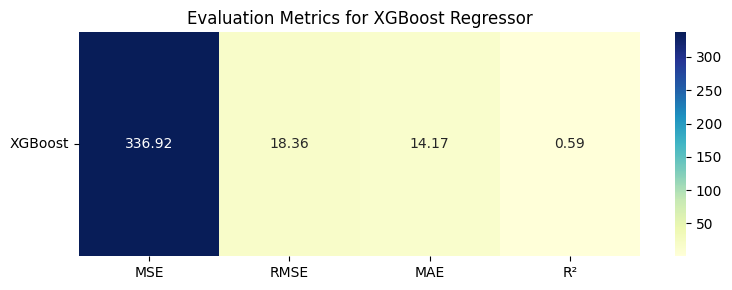

In [ ]:
plt.figure(figsize=(8, 3))
sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Evaluation Metrics for XGBoost Regressor")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [94]:
# --- Determine the maximum possible n_features from TF-IDF for the training data ---
# This helps set a realistic upper bound for TruncatedSVD n_components
temp_tfidf_vectorizer = TfidfVectorizer(min_df=1, max_df=1.0)
temp_tfidf_matrix = temp_tfidf_vectorizer.fit_transform(X_train['combined_text_description'])
max_tfidf_features = temp_tfidf_matrix.shape[1]
print(f"Maximum possible TF-IDF features in training data: {max_tfidf_features}")


Maximum possible TF-IDF features in training data: 43594


#### -------------   Checking few more modeling strategies like HistgradientBoosting to get a better performance ------------

In [96]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.metrics import r2_score

In [97]:
models = {
    'HistGBR': HistGradientBoostingRegressor(random_state=42),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train_filtered, y_train)
    y_pred = pipeline.predict(X_test_filtered)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    }

    print(f"{name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")



--- Training HistGBR ---
HistGBR - MSE: 330.38, RMSE: 18.18, MAE: 14.04, R²: 0.59

--- Training Ridge ---


C:\Users\sruth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.03989e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge - MSE: 375.98, RMSE: 19.39, MAE: 15.20, R²: 0.54

--- Training Lasso ---
Lasso - MSE: 420.95, RMSE: 20.52, MAE: 16.25, R²: 0.48


In [100]:
metrics_df = pd.DataFrame(results).T  # Transpose: models as rows, metrics as columns


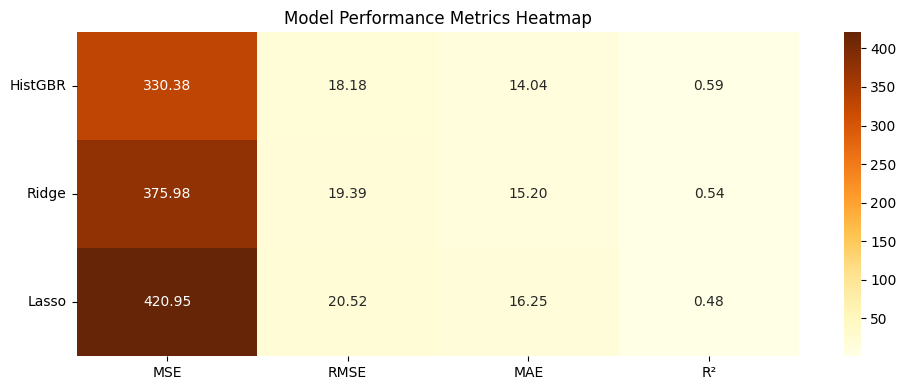

In [101]:
plt.figure(figsize=(10, 4))
sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap="YlOrBr", cbar=True)
plt.title("Model Performance Metrics Heatmap")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


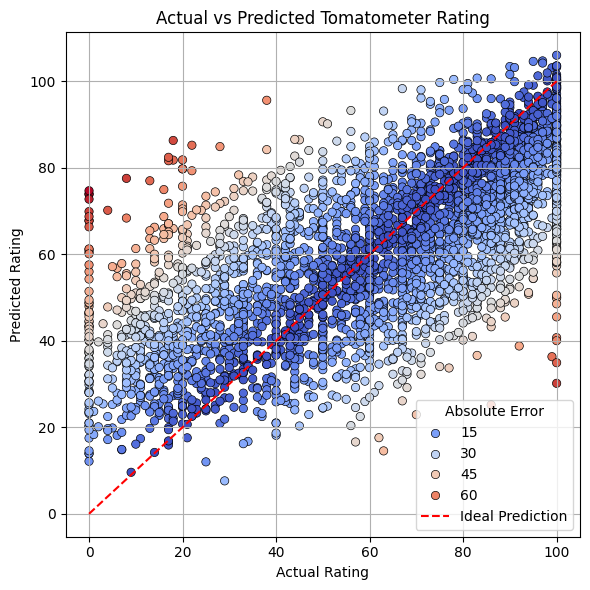

In [108]:
errors = np.abs(y_test - y_pred)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, hue=errors, palette="coolwarm", edgecolor="black")
plt.plot([0, 100], [0, 100], 'r--', label="Ideal Prediction")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted Tomatometer Rating")
plt.legend(title="Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()


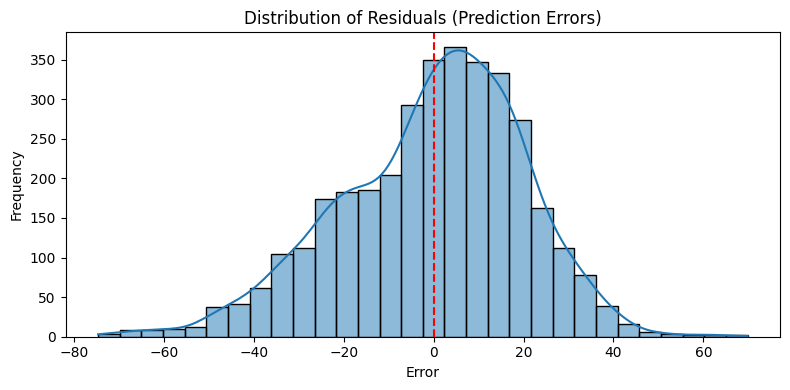

In [103]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals (Prediction Errors)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### ----------------- Tuning and Checking HistGradientBoosting -------------

In [45]:
from sklearn.ensemble import HistGradientBoostingRegressor

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])

In [46]:
from scipy.stats import randint, uniform

# param_distributions = {
#     'regressor__learning_rate': uniform(0.03, 0.2),      # e.g., 0.03 to 0.23
#     'regressor__max_iter': randint(100, 300),            # Number of boosting rounds
#     'regressor__max_leaf_nodes': randint(20, 40),        # Controls tree complexity
#     'regressor__min_samples_leaf': randint(10, 50),      # Regularization
#     'regressor__l2_regularization': uniform(0.0, 1.0)     # Helps generalization
# }


param_distributions = {
    'regressor__learning_rate': [0.1],
    'regressor__max_iter': [100],
    'regressor__max_leaf_nodes': [31],
    'regressor__min_samples_leaf': [20],
    'regressor__l2_regularization': [0.1]
}

In [47]:
from sklearn.model_selection import RandomizedSearchCV

random_search_hgbr = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=15,                # You can increase to 30 if time permits
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [48]:
random_search_hgbr.fit(X_train_filtered, y_train)

C:\Users\sruth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=15. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['runtime',
                                                                                'audience_count',
                                                                                'tomatometer_count',
                                                                                'audience_rating',
                                                                                'tomatometer_top_critics_count']),
                                                                              ('text',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer()),
                                                                                               ('svd',
                                                                                                TruncatedSVD(random_sta...
                                                                               ['original_release_date',
                                                                                'streaming_release_date'])])),
                                             ('regressor',
                                              HistGradientBoostingRegressor(random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'regressor__l2_regularization': [0.1],
                                        'regressor__learning_rate': [0.1],
                                        'regressor__max_iter': [100],
                                        'regressor__max_leaf_nodes': [31],
                                        'regressor__min_samples_leaf': [20]},
                   random_state=42, scoring='r2', verbose=2)

In [49]:
from sklearn.metrics import r2_score

print("Best Parameters:")
print(random_search_hgbr.best_params_)

best_model = random_search_hgbr.best_estimator_
y_pred = best_model.predict(X_test_filtered)

print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

Best Parameters:
{'regressor__min_samples_leaf': 20, 'regressor__max_leaf_nodes': 31, 'regressor__max_iter': 100, 'regressor__learning_rate': 0.1, 'regressor__l2_regularization': 0.1}
R² Score: 0.5911


In [ ]:
param_distributions = {
    'regressor__learning_rate': [0.1],
    'regressor__max_iter': [100],
    'regressor__max_leaf_nodes': [31],
    'regressor__min_samples_leaf': [20],
    'regressor__l2_regularization': [0.1]
}

In [141]:
print("\n--- XGBoost Regression Pipeline created ---")

# --- 5. Define Parameter Distributions for Randomized Search ---
# IMPORTANT FIX: Adjust upper bound for n_components based on actual TF-IDF features
# The upper bound for n_components must be <= max_tfidf_features - 1 (or n_samples - 1, whichever is smaller)
# Let's cap it at a reasonable number for tuning, but ensure it's always valid.
# For example, if max_tfidf_features is 267, then max_n_components should be 266.
# We'll use min(max_tfidf_features - 1, 500) to cap it at 500 for larger datasets, but respect the actual feature count.
max_svd_components_for_tuning = min(max_tfidf_features - 1, X_train.shape[0] - 1, 500)
if max_svd_components_for_tuning < 10: # Ensure a minimum valid range for randint
    max_svd_components_for_tuning = max(1, max_svd_components_for_tuning) # At least 1 component
    svd_lower_bound = 1
else:
    svd_lower_bound = 10 # Start from 10 components if enough features exist




--- XGBoost Regression Pipeline created ---


### -----------Hyper tuning tried but taking more then 12 hrs and due to memory issues it does't complete properly -----------------

In [142]:

param_distributions = {
    'regressor__n_estimators': randint(200, 1500),
    'regressor__learning_rate': uniform(0.01, 0.19),
    'regressor__max_depth': randint(4, 12),
    'regressor__subsample': uniform(0.6, 0.3),
    'regressor__colsample_bytree': uniform(0.6, 0.3),
    'regressor__gamma': uniform(0, 0.3),
    'regressor__reg_alpha': uniform(0, 0.5),
    'regressor__reg_lambda': uniform(0, 0.5),
    'preprocessor__text__svd__n_components': randint(svd_lower_bound, max_svd_components_for_tuning)
}

In [143]:
print(f"SVD n_components tuning range: [{svd_lower_bound}, {max_svd_components_for_tuning}]")


SVD n_components tuning range: [10, 500]


In [144]:
# --- 6. Set up RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=20, # Adjust based on your computational budget
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=1 # Keep n_jobs=1 for stability in most environments
)


In [ ]:
print("\n--- Performing Randomized Search for XGBoost Regressor Hyperparameters ---")
random_search.fit(X_train_filtered, y_train)
print("Randomized Search complete.")



--- Performing Randomized Search for XGBoost Regressor Hyperparameters ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END preprocessor__text__svd__n_components=112, regressor__colsample_bytree=0.8389628960580698, regressor__gamma=0.05503043695984914, regressor__learning_rate=0.15814129005182617, regressor__max_depth=8, regressor__n_estimators=321, regressor__reg_alpha=0.07799726016810132, regressor__reg_lambda=0.02904180608409973, regressor__subsample=0.8598528437324805; total time=  27.4s
[CV] END preprocessor__text__svd__n_components=112, regressor__colsample_bytree=0.8389628960580698, regressor__gamma=0.05503043695984914, regressor__learning_rate=0.15814129005182617, regressor__max_depth=8, regressor__n_estimators=321, regressor__reg_alpha=0.07799726016810132, regressor__reg_lambda=0.02904180608409973, regressor__subsample=0.8598528437324805; total time=  30.9s
[CV] END preprocessor__text__svd__n_components=112, regressor__colsample_bytree=0.8389628960580698,

In [ ]:
# --- 7. Get the Best Model and Parameters ---
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_rmse = -random_search.best_score_

print(f"\nBest parameters found: {best_params}")
print(f"Best cross-validation RMSE: {best_rmse:.4f}")

In [ ]:
# --- 8. Evaluate the Best Model on the Test Set ---
y_pred = best_model.predict(X_test_filtered)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print(f"\nMean Squared Error (MSE) on test set: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse:.4f}")
print(f"Mean Absolute Error (MAE) on test set: {mae:.4f}")
print(f"R-squared (R2) on test set: {r2:.4f}")


### ---------------- Load the model to use in streamlit application -----------------

In [51]:
import joblib 

In [52]:
print("\n--- Saving the trained model and input columns ---")
joblib.dump(best_model, 'xgboost_regression_model.pkl')
print("Trained model saved as 'xgboost_regression_model.pkl'")

joblib.dump(all_transformer_input_cols, 'model_input_columns.pkl')
print("Model input columns saved as 'model_input_columns.pkl'")

print("\n--- Training and model saving complete ---")


--- Saving the trained model and input columns ---
Trained model saved as 'xgboost_regression_model.pkl'
Model input columns saved as 'model_input_columns.pkl'

--- Training and model saving complete ---
